In [2]:
import torch
import torch.nn as nn
import torchvision
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
import torch.optim as optim 
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid 
import sklearn.metrics as metrics
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np

In [3]:
# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


## Load Data

In [27]:
DATA_DIR = "./chest_xray" 
data_dir_train = DATA_DIR + "/train"
data_dir_val = DATA_DIR + "/val"
data_dir_test = DATA_DIR + "/test"

In [28]:
# Some desired transforms for ResNet50
# https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50
transform = transforms.Compose(
    [
        transforms.Resize(size = (256, 256)),
        transforms.CenterCrop(size=(224, 224)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # 
    ]
)
USE_AUGMENT = True
train_transform = transforms.Compose([
        transforms.RandAugment(),
        transform,
    ]) if USE_AUGMENT else transform

In [29]:
BATCH_SIZE = 32
NUM_WORKERS = 7 # 7 because that what it suggested in a warning message
PERSISTENT_WORKERS = True # Suggested to do this in a warning message for faster init

In [30]:
dataset_train = datasets.ImageFolder(data_dir_train, train_transform)
dataset_val = datasets.ImageFolder(data_dir_val, transform)
dataset_test = datasets.ImageFolder(data_dir_test, transform)

train_loader = DataLoader(
    dataset_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS, 
    persistent_workers= PERSISTENT_WORKERS
)
val_loader = DataLoader(
    dataset_val, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    persistent_workers= PERSISTENT_WORKERS
)
test_loader = DataLoader(
    dataset_test, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    persistent_workers= PERSISTENT_WORKERS
)

In [31]:
print(f'Size of train dataset: {len(dataset_train)}')
print(f'Size of validation dataset: {len(dataset_val)}')
print(f'Size of test dataset: {len(dataset_test)}')

Size of train dataset: 5216
Size of validation dataset: 16
Size of test dataset: 624


Text(0.5, 1.0, 'Distribution of validation set')

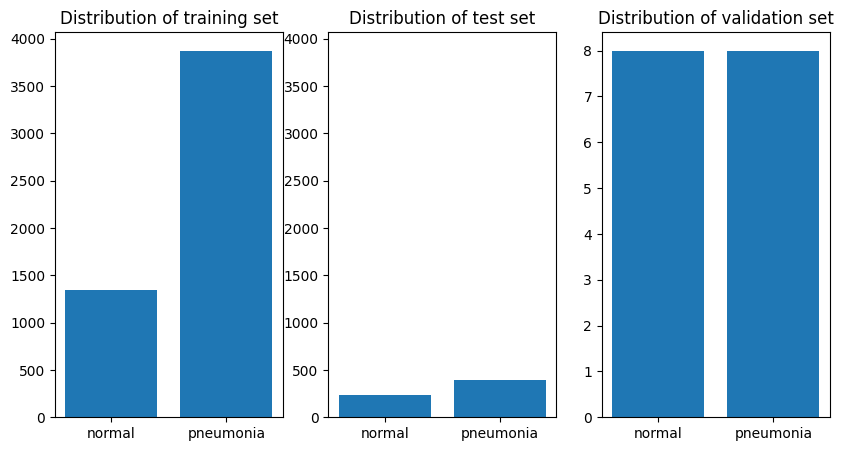

In [32]:
# plot distribution of each data set
labels = ["normal", "pneumonia"]
labels_num = [0,1]
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))

# Bar for training
pneumonia = np.count_nonzero(dataset_train.targets)
normal = len(dataset_train.targets) - pneumonia
ax1.bar(labels_num, [normal,pneumonia])
ax1.set_xticks(labels_num, labels)
ax1.set_title("Distribution of training set")
ylim = ax1.get_ylim()

# Bar for testing
pneumonia = np.count_nonzero(dataset_test.targets)
normal = len(dataset_test.targets) - pneumonia
ax2.bar(labels_num, [normal,pneumonia])
ax2.set_xticks(labels_num, labels)
ax2.set_title("Distribution of test set")
ax2.set_ylim(ylim)

# Bar for validation
pneumonia = np.count_nonzero(dataset_val.targets)
normal = len(dataset_val.targets) - pneumonia
ax3.bar(labels_num, [normal,pneumonia])
ax3.set_xticks(labels_num, labels)
ax3.set_title("Distribution of validation set")
#ax2.set_ylim(ylim)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


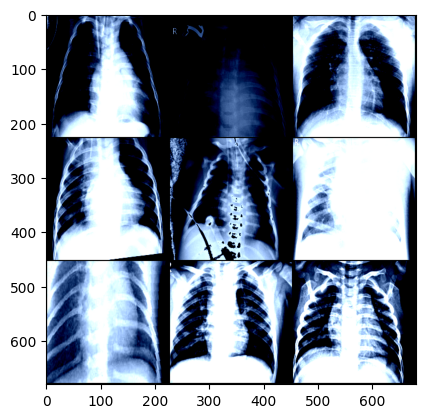

In [33]:
#Plot some example images
examples = next(iter(train_loader))
images, labels = examples
grid = make_grid(images[:9], nrow=3)
plt.imshow(grid.permute(1, 2, 0))

## CNN model

In [34]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv_layer = nn.Conv2d(in_channels,out_channels,kernel_size) 
        self.pooling_layer = nn.MaxPool2d(2,2)
    def forward(self, x):
        x = self.conv_layer(x)
        x = nn.ReLU()(x)
        x = self.pooling_layer(x)
        return x 

In [35]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Assuming input_shape=(224,224,3) and padding = 0
        self.feature_extractor = nn.Sequential(
            ConvBlock(3,64,(3,3)), # 222,222,64 -> 111,111,64
            ConvBlock(64,128,(3,3)), #109,109,128 -> 54,54,128
            ConvBlock(128,256,(3,3)), # 52,52,256 -> 26,26,256
            ConvBlock(256,512,(3,3)) # 24,24,512 -> 12,12,512
        )
        self.flatten = nn.Flatten() # 12*12*512
        self.classification_head = nn.Sequential(
            nn.Linear(in_features=12*12*512, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=num_classes)
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.classification_head(x)
        return x

In [36]:
class Model(L.LightningModule):
    def __init__(self, cnn):
        super().__init__()
        self.cnn = cnn
        
        self.loss = nn.CrossEntropyLoss()
        metrics = MetricCollection([
            BinaryAccuracy(),
            BinaryF1Score(),
            BinaryPrecision(),
            BinaryRecall()
        ])
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        
    def forward(self, x):
        output = self.cnn(x)
        return output
    
    def training_step(self, batch, batch_idx):
        images, labels = batch 
        preds = self(images)
        loss = self.loss(preds, labels)
        self.train_metrics.update(torch.argmax(preds, dim=1), labels)
        #out = self.train_metrics(torch.argmax(preds, dim=1),labels)
        #self.log_dict(out, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, batch_size=images.shape[0])
        return loss
        #return {'loss':loss, 'metrics':self.train_metrics}
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch 
        preds = self(images)
        loss = self.loss(preds, labels)
        self.val_metrics.update(torch.argmax(preds, dim=1), labels)
        #out = self.val_metrics(torch.argmax(preds, dim=1), labels)
        #self.log_dict(out, prog_bar=False)
        self.log("val_loss", loss, on_step=False, on_epoch=True, batch_size=images.shape[0])
        return loss
        #return {'val_loss':loss, 'metrics':self.val_metrics}
    
    def on_train_epoch_end(self):
        performance = self.train_metrics.compute()
        self.log_dict(performance)
        self.train_metrics.reset()
        
    def on_validation_epoch_end(self):
        performance = self.val_metrics.compute()
        self.log_dict(performance)
        self.val_metrics.reset()   
        
    def configure_optimizers(self, lr = 1e-3):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        return optimizer
        

In [38]:
early_stopping = L.pytorch.callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=1e-6)
checkpoint = L.pytorch.callbacks.ModelCheckpoint(dirpath='pneumonia_model/')
callbacks = [early_stopping, checkpoint]
logger = TensorBoardLogger("lightning_logs",
                           name=f"simple/{'augment' if USE_AUGMENT else 'original'}",
                           )


In [39]:
trainer = L.Trainer(
    accelerator = 'auto',
    devices=1,
    logger=logger,
    max_epochs=100, 
    callbacks=callbacks)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [40]:
cnn = CNN(num_classes=2)
model = Model(cnn)
torch.set_float32_matmul_precision('medium')
trainer.fit(model,train_dataloaders=train_loader,val_dataloaders=val_loader)

Missing logger folder: lightning_logs/augment
/home/roger/.local/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/roger/jupyter_data/gits/D7047E-Project/pneumonia_model exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | cnn           | CNN              | 6.3 M  | train
1 | loss          | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.087    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/roger/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
